# Simulating sound changes in real and artificial lexicons

This aims to address several questions:
1. Does simulating sound changes in a lexicon result in more homophones overall?
2. Do simulated changes result in more homophones for *short* words than *long* words?

## Simulating in real IPHOD lexicon


### Load and preprocess data


In [26]:
import pandas as pd 
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import src.utils as utils
import math
import seaborn as sns
from tqdm import tqdm
from os import listdir
import random
import numpy as np
from collections import Counter

In [27]:
df = pd.read_csv("data/raw/IPhODv2.0_REALS/IPhOD2_Words.txt", sep="\t")
PHON_COLUMN = 'StTrn'

In [28]:
len(df)

54030

In [29]:
df_processed = utils.preprocess_for_analysis(df, phon_column=PHON_COLUMN, verbose=True)
print("{X} words in final analysis".format(X=len(df_processed)))

Number of tokens: 54029
Number of tokens: 54029


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Number of tokens: 51956
51956 words in final analysis


### Extract number of homophones and length data

In [30]:
TOTAL_HOMOPHONES = len(df_processed[df_processed['num_homophones']>=1])
PERCENT_LEXICON = (TOTAL_HOMOPHONES/len(df_processed)) * 100
PERCENT_LEXICON = round(PERCENT_LEXICON, 2)
print("{X} homophones".format(X=TOTAL_HOMOPHONES))
print("{X}% of lexicon".format(X=PERCENT_LEXICON))

1703 homophones
3.28% of lexicon


In [31]:
FORMULA = 'num_homophones ~ NSyll'

In [32]:
result_original = sm.poisson(formula=FORMULA, data=df_processed).fit(disp=0)

In [33]:
LENGTH_COEF = result_original.params['NSyll']
LENGTH_COEF

-1.6019300045541562

In [34]:
pd.pivot_table(df_processed, values='num_homophones',
              columns=['NSyll'],
              aggfunc=np.sum)

NSyll,0,1,2,3,4,5,6,7,8,9,12
num_homophones,0,1296,643,104,19,8,3,0,0,0,0


In [35]:
counts = Counter(df_processed['num_homophones'])
counts

Counter({0: 50253, 2: 198, 1: 1431, 5: 6, 3: 56, 4: 12})

### Construct sound change rules

Now we construct a set of sound changes that can occur in a lexicon. For now, we simulate *unconditioned* sound change: that is, what happens when a single phone changes to another phone *across* the lexicon?

In [36]:
# The IPA pronunciation guide for IPHOD seems different from my understanding?
rules = [('AA', 'AE'), # "tot" --> "tat"
         ('T', 'D'), # 'eater' --> 'eader'
         ('P', 'B'), # 'pout' --> 'bout'
         ('K', 'G'), # 'car' --> 'gar',
         ('F', 'V'), # 'far' --> 'var',
         ('S', 'Z'), # 'saw' --> 'zaw',
         ('AY', 'IY'), # 'icy' --> 'eecee'
         # ('D', 'T'), # 'eater' --> 'eader'
         # ('B', 'P'), # 'pout' --> 'bout'
         # ('G', 'K'), # 'car' --> 'gar',
         # ('V', 'F'), # 'far' --> 'var',
         #('Z', 'S'), # 'saw' --> 'zaw',
            ]

In [37]:
def implement_unconditioned_sound_change(wordforms, rule):
    """Implement sound change across a lexicon of phonological wordforms.
    
    Parameters
    ----------
    wordforms: list
       list of strings representing phonological wordforms
    rule: tuple
       tuple with first element representing original sound, second 
       representing new sound
    """
    new_wordforms = [word.replace(rule[0], rule[1]) for word in wordforms]
    return new_wordforms

### Simulate sound changes

Now we simulate sound changes starting from the same initial conditions.

In [13]:
percent_homophone_list, slope_coefs = [], []

In [14]:
for rule in rules:
    df_copy = df.copy()
    df_copy['new_lexicon'] = implement_unconditioned_sound_change(list(df_copy['StTrn']), rule)
    df_copy['unchanged'] = df_copy['new_lexicon'] == df_copy['StTrn']
    df_copy_processed = utils.preprocess_for_analysis(df_copy, phon_column='new_lexicon')
    
    total = len(df_copy_processed[df_copy_processed['num_homophones']>=1]) 
    percent = (total/len(df_copy_processed)) * 100
    percent_homophone_list.append(percent)
        
    result_new = sm.poisson(formula=FORMULA, data=df_copy_processed).fit(disp=0)
    slope_coefs.append(result_new.params['NSyll'])

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [15]:
slope_coefs

[-1.589436261988264,
 -1.6433263949544161,
 -1.6324746737761548,
 -1.6338417362761026,
 -1.5801769625165827,
 -1.5318041072576518,
 -1.500228979833363]

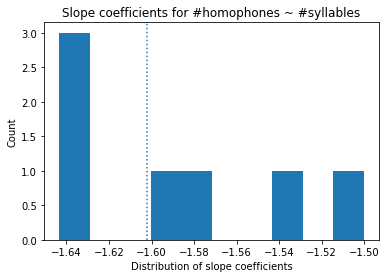

In [16]:
plt.hist(slope_coefs)
plt.axvline(x=LENGTH_COEF, linestyle="dotted")
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
plt.show()

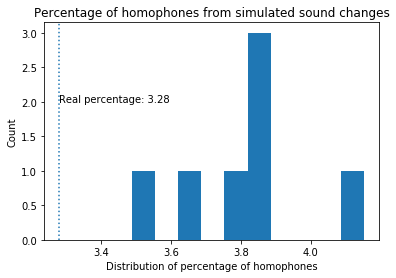

In [17]:
plt.hist(percent_homophone_list)
plt.axvline(x=PERCENT_LEXICON, linestyle="dotted")
plt.xlabel("Distribution of percentage of homophones")
plt.text(s="Real percentage: {X}".format(X=PERCENT_LEXICON),x=PERCENT_LEXICON, y=2)
plt.ylabel("Count")
plt.title("Percentage of homophones from simulated sound changes")
plt.show()

### Simulate sound changes in artificial lexicons

Now we simulate sound changes in artificial lexicons.

In [38]:
PATH = "data/raw/IPhODv2.0_PSEUDO"
PHON_COLUMN = 'StTrn'
sources = []
files = listdir(PATH)
print("Loading pseudo-words from files...")
for f in tqdm(files):
	if "IPhOD2_Pseudos" in f:
		temp = pd.read_csv("{path}/{file_name}".format(path=PATH, file_name=f), sep="\t")
		sources.append(temp)

df_pseudos = pd.concat(sources)

  0%|          | 0/19 [00:00<?, ?it/s]

Loading pseudo-words from files...


100%|██████████| 19/19 [00:13<00:00,  1.69s/it]


In [39]:
df_pseudos = df_pseudos.drop_duplicates(subset=PHON_COLUMN)
print("{X} pseudowords after dropping duplicate wordforms.".format(X=len(df_pseudos)))

761688 pseudowords after dropping duplicate wordforms.


In [20]:
ACTUAL_DISTRIBUTION = Counter(df_processed['NSyll'])
ACTUAL_DISTRIBUTION

Counter({1: 7132,
         3: 14329,
         2: 20759,
         4: 6785,
         5: 2400,
         6: 482,
         7: 56,
         12: 1,
         8: 8,
         9: 1,
         0: 3})

#### Just random words for now

For now, we just ask about the effect of sound changes on completely random lexicons.

In [42]:
ITERATIONS = 10
SIZE = len(df_processed)
print(SIZE)

51956


In [68]:
og_percents, og_nums = [], []
new_percents, new_nums = [], []
og_slopes = []
new_slopes = []

In [70]:
for i in tqdm(list(range(ITERATIONS))):
    
    df_artificial = df_pseudos.sample(SIZE, replace=True)
    df_artificial['Word_recoded'] = df_artificial['Word'].apply(lambda x: x.split(" (")[0])
    df_artificial_processed = utils.preprocess_for_analysis(df_artificial, 
                                                            phon_column=PHON_COLUMN, 
                                                            word_column='Word_recoded',
                                                            verbose=True)
    total_homophones_art = len(df_artificial_processed[df_artificial_processed['num_homophones']>=1])
    percent_lex = (total_homophones_art/len(df_artificial_processed)) * 100
    percent_lex = round(percent_lex, 2)
    
    og_percents.append(percent_lex)
    og_nums.append(total_homophones_art)
    
    result_og = sm.poisson(formula=FORMULA, data=df_artificial_processed).fit(disp=0)
    og_slopes.append(result_og.params['NSyll'])
    
    for rule in rules:
        df_copy = df_artificial.copy()
        df_copy['new_lexicon'] = implement_unconditioned_sound_change(list(df_copy['StTrn']), rule)
        df_copy_processed = utils.preprocess_for_analysis(df_copy, word_column='Word_recoded',
                                                          phon_column='new_lexicon')

        total = len(df_copy_processed[df_copy_processed['num_homophones']>=1]) 
        percent = (total/len(df_copy_processed)) * 100
        new_percents.append(percent)

        result_new = sm.poisson(formula=FORMULA, data=df_copy_processed).fit(disp=0)
        new_slopes.append(result_new.params['NSyll'])

  0%|          | 0/10 [00:00<?, ?it/s]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50236


 10%|█         | 1/10 [00:08<01:18,  8.70s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50210


 20%|██        | 2/10 [00:17<01:09,  8.63s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50169


 30%|███       | 3/10 [00:24<00:58,  8.39s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50141


 40%|████      | 4/10 [00:33<00:50,  8.37s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50263


 50%|█████     | 5/10 [00:41<00:41,  8.29s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50135


 60%|██████    | 6/10 [00:49<00:33,  8.32s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50254


 70%|███████   | 7/10 [00:57<00:24,  8.19s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50234


 80%|████████  | 8/10 [01:05<00:16,  8.08s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50173


 90%|█████████ | 9/10 [01:13<00:08,  8.09s/it]

Number of tokens: 51956
Number of tokens: 51956
Number of tokens: 50264


100%|██████████| 10/10 [01:22<00:00,  8.35s/it]


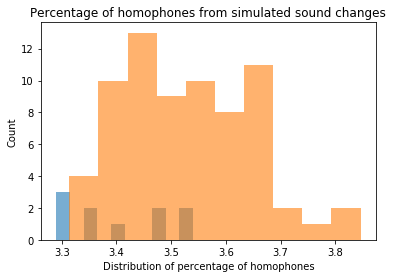

In [71]:
plt.hist(og_percents, label="before simulated sound changes", alpha = .6)
plt.hist(new_percents, label="after simulated sound changes", alpha = .6)
# plt.axvline(x=PERCENT_LEXICON, linestyle="dotted")
plt.xlabel("Distribution of percentage of homophones")
# plt.text(s="Real percentage: {X}".format(X=PERCENT_LEXICON),x=PERCENT_LEXICON, y=2)
plt.ylabel("Count")
plt.title("Percentage of homophones from simulated sound changes")
plt.show()

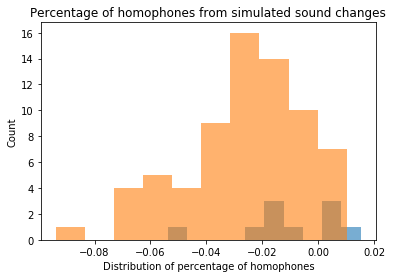

In [72]:
plt.hist(og_slopes, label="before simulated sound changes", alpha = .6)
plt.hist(new_slopes, label="after simulated sound changes", alpha = .6)
# plt.axvline(x=PERCENT_LEXICON, linestyle="dotted")
plt.xlabel("Distribution of percentage of homophones")
# plt.text(s="Real percentage: {X}".format(X=PERCENT_LEXICON),x=PERCENT_LEXICON, y=2)
plt.ylabel("Count")
plt.title("Percentage of homophones from simulated sound changes")
plt.show()